<div style="background-color:rgb(245, 184, 242); color: rgb(70, 11, 83); border: 2px solidrgb(255, 255, 255); padding: 10px; border-radius: 7px;">
Notes on Utility

With only one bacteria, your only need 1 iteration
1 bacteria in iiFBA == FBA aka you only need one iteration

When you have one organism you will converge in one iteration, which is why is collapses to FBA

No need for time and rates because iterative convergence helps lead to the exact behavior we can expect in the first instance. 
^^ As long as growth is limited only by environmental flux and not internal constraints

If alpha zero, no insight to interaction unless there is cross-feeding, in which the consumer will consume after the first iteration
</div>

<div class= "alert alert-block alert-success">
My future steps: <br>
- Plotting sampling (unimportant) <br>
<br>

pip installable!!! (will add to pyPI when done-done)<br>
pip install "git+https://github.com/m-3-lab/iiFBA.git@main#subdirectory=package"

</div>

∑ |vᵢ|


In [1]:
import iifba
from iifba.utils import load_simple_models, load_example_models
import matplotlib.pyplot as plt
import numpy as np

models, media = load_simple_models(4)
EC, BT, media = load_example_models()

rel_abund = np.ones(len(models))  # equal relative abundance for all models
comm = iifba.Community([EC, BT], media, rel_abund=rel_abund, iters=10, objective="fba")
f, F = comm.iifba(early_stop=True) # defualt values

summ = comm.summary()
#comm.env_fluxes

print(summ)  # print summary to console
summ

Set parameter Username
Set parameter LicenseID to value 2684253
Academic license - for non-commercial use only - expires 2026-07-02


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p


Relative abundances set to: [0.5 0.5]
Community Summary (Iteration 9):
Objective: fba
Sum(Obj_i) = 0.7653909124634791

Uptake:
Metabolite      Exchange      Flux  C-Number C-Flux
    so4[e]     EX_so4(e)  0.165017         0  0.00%
    ca2[e]     EX_ca2(e)  0.006002         0  0.00%
    cu2[e]     EX_cu2(e)  0.006002         0  0.00%
    mg2[e]     EX_mg2(e)  0.006002         0  0.00%
    mn2[e]     EX_mn2(e)  0.006002         0  0.00%
    no3[e]     EX_no3(e) 37.728646         0  0.00%
cobalt2[e] EX_cobalt2(e)  0.006002         0  0.00%
    fe2[e]     EX_fe2(e)  0.009052         0  0.00%
      k[e]       EX_k(e)  0.006002         0  0.00%
  cys_L[e]   EX_cys_L(e)  0.040368         3  0.14%
    fe3[e]     EX_fe3(e)  0.006002         0  0.00%
  glc_D[e]   EX_glc_D(e) 10.000000         6 70.52%
    nh4[e]     EX_nh4(e) 10.270851         0  0.00%
    zn2[e]     EX_zn2(e)  0.006002         0  0.00%
     cl[e]      EX_cl(e)  0.006002         0  0.00%
     pi[e]      EX_pi(e)  0.904874       

Metabolite,Exchange,Flux,C-Number,C-Flux
so4[e],EX_so4(e),0.165017,0,0.00%
ca2[e],EX_ca2(e),0.006002,0,0.00%
cu2[e],EX_cu2(e),0.006002,0,0.00%
mg2[e],EX_mg2(e),0.006002,0,0.00%
mn2[e],EX_mn2(e),0.006002,0,0.00%
no3[e],EX_no3(e),37.728646,0,0.00%
cobalt2[e],EX_cobalt2(e),0.006002,0,0.00%
fe2[e],EX_fe2(e),0.009052,0,0.00%
k[e],EX_k(e),0.006002,0,0.00%
cys_L[e],EX_cys_L(e),0.040368,3,0.14%



 1
Set parameter Username
Set parameter LicenseID to value 2684253
Academic license - for non-commercial use only - expires 2026-07-02
Iteration: 0
Running FBA for model 1/1...
Iteration: 1
Running FBA for model 1/1...
Convergence achieved.

 2
Iteration: 0
Running FBA for model 1/1...
Iteration: 1
Running FBA for model 1/1...
Convergence achieved.

 3
Relative abundances set to: [0.5 0.5]
Iteration: 0
Running FBA for model 1/2...
Running FBA for model 2/2...
Re-running Optimization due to over-saturation of environment fluxes.
Running FBA for model 1/2...
Running FBA for model 2/2...
Iteration: 1
Running FBA for model 1/2...
Running FBA for model 2/2...
Convergence achieved.

 4
Relative abundances set to: [0.5 0.5]
Iteration: 0
Running FBA for model 1/2...
Running FBA for model 2/2...
Iteration: 1
Running FBA for model 1/2...
Running FBA for model 2/2...
Convergence achieved.

 5
Relative abundances set to: [0.5 0.5]
Iteration: 0
Running FBA for model 1/2...
Running FBA for model 2/

Text(0.5, 0.98, 'iiFBA Results for Various Simulations')

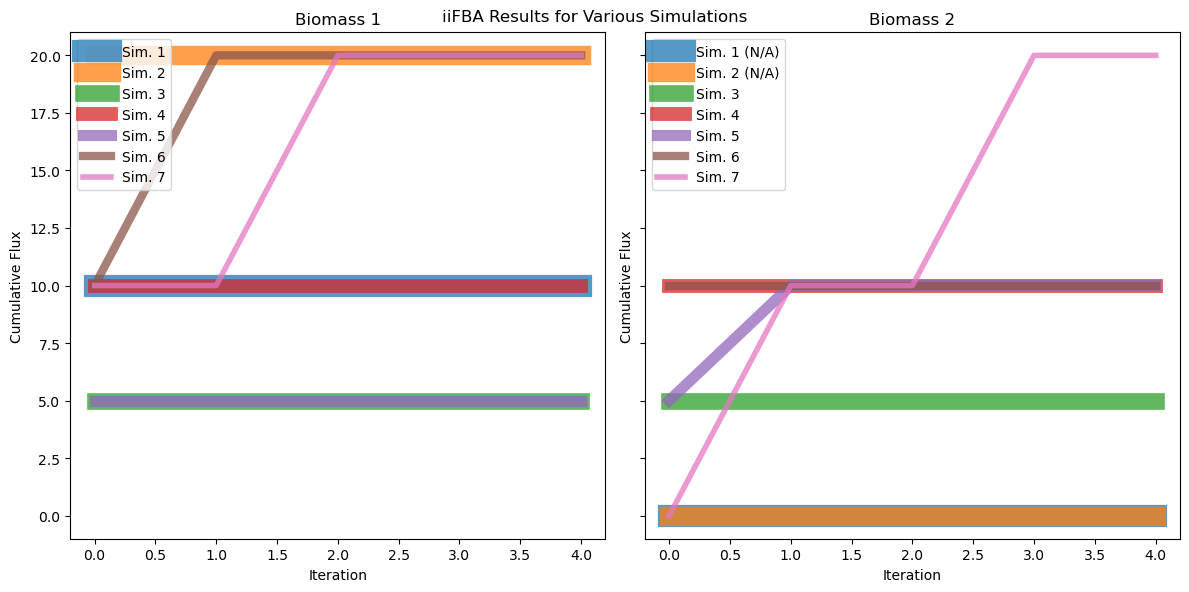

In [1]:
import iifba
from iifba.utils import load_simple_models
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
for sim_idx in [1,2,3, 4, 5, 6, 7]:
	print("\n", sim_idx)
	models, media = load_simple_models(sim_idx)

	rel_abund = np.ones(len(models))  # equal relative abundance for all models
	rel_abund[-1] = 1 * rel_abund[0]  # make last model more abundant
	comm = iifba.Community(models, media, rel_abund=rel_abund, iters=5)
	f, F = comm.iifba(early_stop=True, v=True) # defualt values

	biomass_id = "exchangeBio1"
	ax1 = iifba.iifba_vis(F.loc[0,:][biomass_id], ax=ax1, line_lab=sim_idx)
	if sim_idx > 2:
		biomass_id = "exchangeBio2"
		ax2 = iifba.iifba_vis(F.loc[1,:][biomass_id], ax=ax2, line_lab=sim_idx)
	else:
		ax2 = iifba.iifba_vis(np.zeros(5), ax=ax2, line_lab=sim_idx)
#adjust plot methods
for line_idx, line in enumerate(ax1.get_lines()):
	line.set_alpha(0.75)  # Set transparency for all lines in ax1
	line.set_lw(2*(8-line_idx))  # Vary line width for each line
for line_idx, line in enumerate(ax2.get_lines()):
	line.set_alpha(0.75)  # Set transparency for all lines in ax2
	line.set_lw(2*(8-line_idx))
# Update legends
ax1.legend(['Sim. 1', 'Sim. 2', 'Sim. 3', 'Sim. 4', 'Sim. 5', "Sim. 6", "Sim. 7"])
ax2.legend(['Sim. 1 (N/A)', 'Sim. 2 (N/A)', 'Sim. 3', 'Sim. 4', 'Sim. 5', "Sim. 6", "Sim. 7"])
# Method 3: Get and modify legend properties
legend1 = ax1.get_legend()
legend2 = ax2.get_legend()
# Use display() to show the updated plot
ax1.set_title("Biomass 1")
ax2.set_title("Biomass 2")
fig.tight_layout()
fig.suptitle(r"iiFBA Results for Various Simulations")


# Simple Models Implementation iiFBA



 1
Set parameter Username
Set parameter LicenseID to value 2684253
Academic license - for non-commercial use only - expires 2026-07-02
Iterations set to: 10
Relative abundances set to: [1.]
Iteration: 0
False [[10.]]
(1,)
(1,)
Ex_A -10.0
Overshoot 1.0
Iteration: 1
False [[0.]]
(1,)
(1,)
Ex_A [-0.]
Overshoot 0.0
Iteration: 2
False [[0.]]
(1,)
(1,)
Ex_A [-0.]
Overshoot 0.0
Iteration: 3
False [[0.]]
(1,)
(1,)
Ex_A [-0.]
Overshoot 0.0
Iteration: 4
False [[0.]]
(1,)
(1,)
Ex_A [-0.]
Overshoot 0.0
Iteration: 5
False [[0.]]
(1,)
(1,)
Ex_A [-0.]
Overshoot 0.0
Iteration: 6
False [[0.]]
(1,)
(1,)
Ex_A [-0.]
Overshoot 0.0
Iteration: 7
False [[0.]]
(1,)
(1,)
Ex_A [-0.]
Overshoot 0.0
Iteration: 8
False [[0.]]
(1,)
(1,)
Ex_A [-0.]
Overshoot 0.0
Iteration: 9
False [[0.]]
(1,)
(1,)
Ex_A [-0.]
Overshoot 0.0

 2
Iterations set to: 10
Relative abundances set to: [1.]
Iteration: 0
False [[10.  0.]]
(2,)
(2,)
Ex_A -10.0
Ex_B 0.0
Overshoot 1.0
Iteration: 1
False [[0. 0.]]
(2,)
(2,)
Ex_A [-0.]
Ex_B 0.0
Overs

Text(0.5, 0.98, 'iiFBA Results for Various Situations')

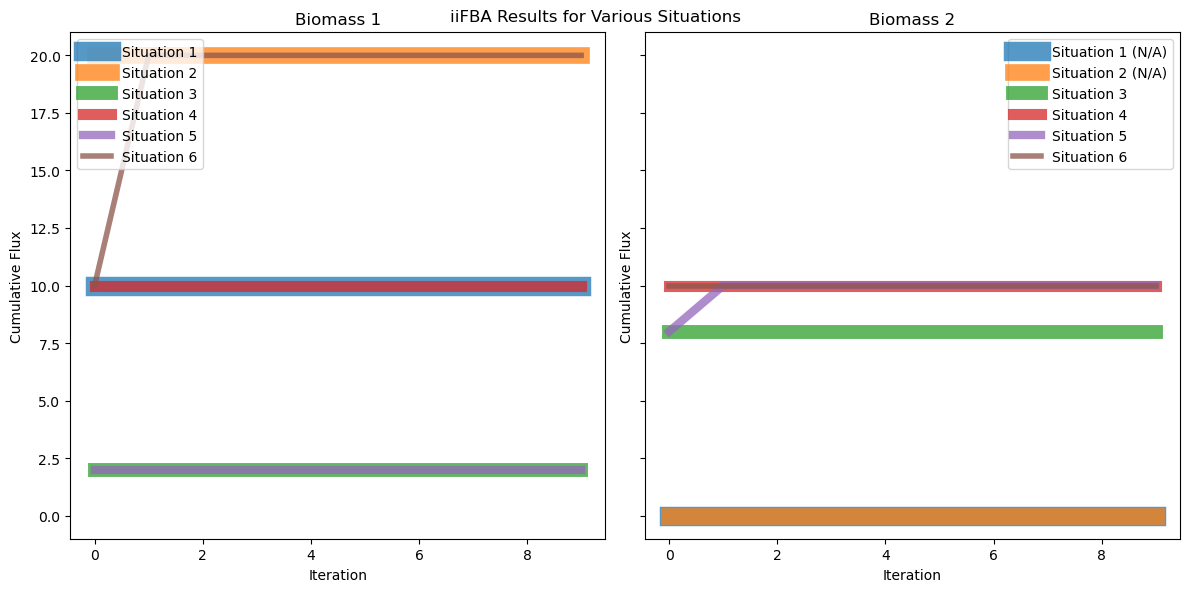

In [1]:
import iifba
from iifba.utils import load_simple_models
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
for sit_idx in [1,2,3, 4, 5, 6]:
	print("\n", sit_idx)
	models, media = load_simple_models(sit_idx)

	rel_abund = np.ones(len(models))  # equal relative abundance for all models
	rel_abund[-1] = 4 * rel_abund[0]  # make last model more abundant
	f, F = iifba.iipfba(models, media, rel_abund=rel_abund, iters=10) # defualt values

	biomass_id = "exchangeBio1"
	ax1 = iifba.iifba_vis(F.loc[0,:][biomass_id], ax=ax1, line_lab=sit_idx)
	if sit_idx > 2:
		biomass_id = "exchangeBio2"
		ax2 = iifba.iifba_vis(F.loc[1,:][biomass_id], ax=ax2, line_lab=sit_idx)
	else:
		ax2 = iifba.iifba_vis(np.zeros(10), ax=ax2, line_lab=sit_idx)
#adjust plot meh
for line_idx, line in enumerate(ax1.get_lines()):
	line.set_alpha(0.75)  # Set transparency for all lines in ax1
	line.set_lw(2*(7-line_idx))  # Vary line width for each line
for line_idx, line in enumerate(ax2.get_lines()):
	line.set_alpha(0.75)  # Set transparency for all lines in ax2
	line.set_lw(2*(7-line_idx))
# Update legends
ax1.legend(['Situation 1', 'Situation 2', 'Situation 3', 'Situation 4', 'Situation 5', "Situation 6"])
ax2.legend(['Situation 1 (N/A)', 'Situation 2 (N/A)', 'Situation 3', 'Situation 4', 'Situation 5', "Situation 6"])
# Method 3: Get and modify legend properties
legend1 = ax1.get_legend()
legend2 = ax2.get_legend()
# Use display() to show the updated plot
ax1.set_title("Biomass 1")
ax2.set_title("Biomass 2")
fig.tight_layout()
fig.suptitle(r"iiFBA Results for Various Situations")


In [1]:
from IPython.display import display
for line in ax1.get_lines():
	line.set_alpha(0.75)  # Set transparency for all lines in ax1
	line.set_lw(2)
for line in ax2.get_lines():
	line.set_alpha(0.75)  # Set transparency for all lines in ax1
	line.set_lw(2)

ax1.get_lines()[2].set_lw(4)# 5 overlaps with 3
ax1.get_lines()[2].set_ls("--")

ax2.get_lines()[3].set_lw(4) # 5 overlaps with 4
ax2.get_lines()[3].set_ls("--")
ax2.get_lines()[2].set_lw(4) # 6 overlaps with 3
ax2.get_lines()[2].set_ls("--")
ax2.get_lines()[0].set_lw(0)
ax2.get_lines()[1].set_lw(0)

# Update legends
ax1.legend(['Situation 1', 'Situation 2', 'Situation 3', 'Situation 4', 'Situation 5', "Situation 6"])
ax2.legend(['Situation 1 (N/A)', 'Situation 2 (N/A)', 'Situation 3', 'Situation 4', 'Situation 5', "Situation 6"])

# Method 3: Get and modify legend properties
legend1 = ax1.get_legend()
legend2 = ax2.get_legend()

# Use display() to show the updated plot
ax1.set_title("Biomass 1")
ax2.set_title("Biomass 2")


fig.tight_layout()
fig.suptitle(r"iiFBA Results for Various Situations")
display(fig)


NameError: name 'ax1' is not defined

## Compartmentalized FBA 

In [1]:
from cobra import Model

for sit_idx in range(1, 7):
	models, media = load_simple_models(sit_idx)
	print(f"\nSituation {sit_idx} Models:")
	for model in models:
		for ex in model.exchanges:
			ex.lower_bound = 0  # Set lower bound to 0 for all exchange reactions
		for med_ex in media.keys():
			if med_ex in model.reactions:
				model.reactions.get_by_id(med_ex).lower_bound = media[med_ex]
				

	for model_idx, model in enumerate(models):
		# Change compartments for each model so that models[i] uses e0 and c{i+1} compartments
		for met in model.metabolites:
			if met.compartment == "c":
				met.compartment = f"c{model_idx+1}"
				id = met.id.replace("bio1", "bio_c").replace("bio2", "bio_c").replace("_c", f"_c{model_idx+1}")
				met.id = id
		
		for rxn in model.reactions:
			# Change the compartment of the reaction to match the new metabolite compartments
			for met in rxn.metabolites.copy():
				if met.compartment.startswith("c"):
					if not rxn.id.endswith(f"_{met.compartment}"):
					# Find the metabolite object with the new id in the model
						rxn.id = rxn.id + f"_{met.compartment}"

	# Merge the two models into a single compartmentalized model
	comp_model = Model(f"compartmentalized_sit{sit_idx+1}")
	for m in models:
		comp_model.add_metabolites([met.copy() for met in m.metabolites])
		comp_model.add_reactions([rxn.copy() for rxn in m.reactions])


	# Example: print the objective value after optimizing the compartmentalized model
	objective_reactions = [comp_model.reactions.get_by_id(f"exchangeBio{i+1}_c{i+1}") for i in range(len(models))]
	objective_rxns_coef = [1] * len(objective_reactions)

			
	comp_model.objective = dict(zip(objective_reactions, objective_rxns_coef))

	solution = comp_model.optimize()
	print(f"{comp_model.id}, Objective value: {solution.objective_value}")
	print(solution.fluxes)

NameError: name 'load_simple_models' is not defined

**Sit 1 & 2 :**
Matches

**Sit 3:**
Kinda Matches (obj matches, but flux divided incorrectly)
Degenerate solution so any division of metA functions equally (all to the first is simplest)

**Sit 4:**
Matches

**Sit 5:**
Wrong because doesnt account for BiomassFromA_c2 using some A before BiomassFromA_c1 can get to it... 15 iiFBA makes more sense

**Sit 6:**
Matches

situation   iifba bio1   cfba bio1   iifba bio2     cfba bio2       iifba sum    cfba sum
1               10          10          na              na              10          10
2               20          20          na              na              20          20
3               5           10          5               0               10          10
4               10          10          10              10              20          20
5               5           10          10              10              15          20  
6				20			20			10				10				30			30

## MICOM


In [32]:
import pandas as pd
import cobra
from cobra.util.solver import linear_reaction_coefficients 
models, media = load_simple_models(3)

community = pd.DataFrame({
	"id": ["Org1", "Org2"],
	"file": ["../Examples/SImple_Models/sit_III_1.json", "../Examples/SImple_Models/sit_III_2.json"],
	"abundance": [0.2, 0.8]
})

media = {"EX_A_m": 10}
from micom import Community
import micom
community = Community(community)

community.medium = media
community.solver = "gurobi"



solutions = community.cooperative_tradeoff(fraction=[1,0.8, 0], pfba=True)
for idx, sol in enumerate(solutions["solution"]):
	print(f"Solution alpha: {solutions['tradeoff'][idx]}")
	print(sol.members)
	#print("End Abundances:", (sol.members["abundance"] * sol.members["growth_rate"]).to_numpy()[0:-1])
	print("-" * 60)

for rxn in community.reactions:
	print(rxn)

print((community.reactions.get_by_id("Ex_A__Org1").metabolites))

Output()

[07/08/25 11:30:16] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=20491;file:///home/rseag/anaconda3/envs/MBE2/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=463716;file:///home/rseag/anaconda3/envs/MBE2/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

Solution alpha: 1.0
              abundance  growth_rate  reactions  metabolites
compartments                                                
Org1                0.2     2.941176          4            3
Org2                0.8    11.764706          4            3
medium              NaN          NaN          1            1
------------------------------------------------------------
Solution alpha: 0.8
              abundance  growth_rate  reactions  metabolites
compartments                                                
Org1                0.2     2.352941          4            3
Org2                0.8     9.411765          4            3
medium              NaN          NaN          1            1
------------------------------------------------------------
Solution alpha: 0.0
              abundance  growth_rate  reactions  metabolites
compartments                                                
Org1                0.2     0.000004          4            3
Org2                0.8  

Iterations set to: 10
Relative abundances set to: [0.2 0.8]
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9


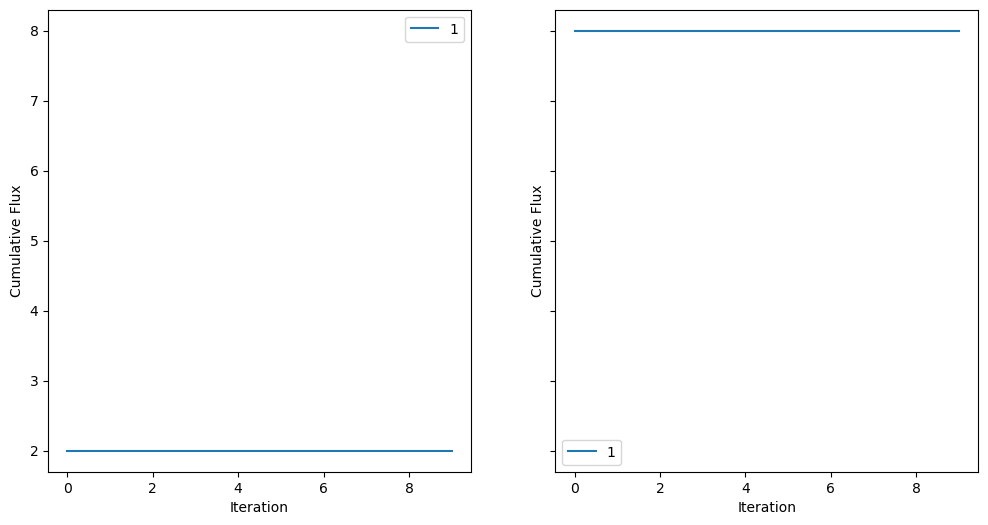

In [16]:
import iifba
from iifba.utils import load_simple_models
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

models, media = load_simple_models(3)

f, F = iifba.iipfba(models, media, rel_abund=[0.2,0.8], iters=10) # defualt values

biomass_id = "exchangeBio1"
ax1 = iifba.iifba_vis(F.loc[0,:][biomass_id], ax=ax1, line_lab=sit_idx)

biomass_id = "exchangeBio2"
ax2 = iifba.iifba_vis(F.loc[1,:][biomass_id], ax=ax2, line_lab=sit_idx)
